In [1]:
import pandas as pd
import cbsodata
import matplotlib.pyplot as plt
import numpy as np
import functools as ft
from datetime import datetime

todayDate = datetime.today().strftime('%Y_%m_%d')
pd.set_option('display.max_columns', 40)

In [2]:
###################################
# https://cbsodata.readthedocs.io/en/latest/readme_link.html

# chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.cpb.nl/sites/default/files/publicaties/download/cpb-technical-background-document-bvar-models-used-cpb.pdf
###################################

#### GDP
# https://opendata.cbs.nl/statline#/CBS/nl/dataset/84105NED/table?ts=1706684088769
# https://opendata.cbs.nl/statline#/CBS/nl/dataset/84087NED/table?ts=1696490590802

In [3]:
#### WHERE TO SAVE DATA'
output = "../output_mo_qt/"
figures = "../figures/"	

C:\Users\jpark\AppData\Local\Temp\ipykernel_50704\1278732726.py:18: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  data.index = pd.date_range(start = start_date, periods = data.shape[0], freq = "Q").to_period('Q')
C:\Users\jpark\AppData\Local\Temp\ipykernel_50704\1278732726.py:46: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  all_data.index = pd.date_range(start=start_date, periods = all_data.shape[0], freq="Q").to_period('Q')


(119, 152)


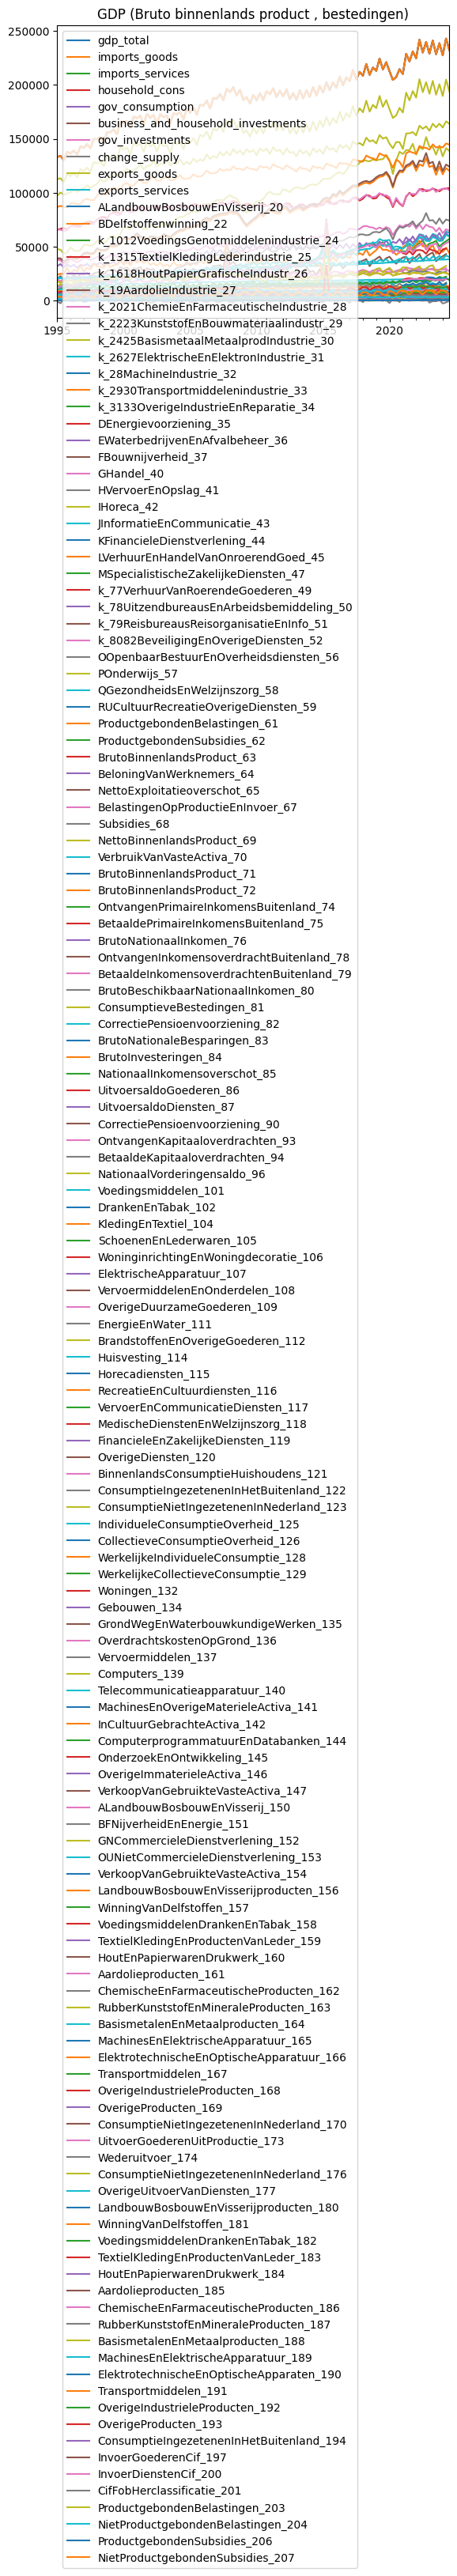

In [4]:
def macro_data_cbs(identifier, verbose = False):
    start_date = '01/01/1995'

    if verbose:
        info = cbsodata.get_info(identifier)
        print(info)
        tables = pd.DataFrame(cbsodata.get_table_list())

    # get data
    data = pd.DataFrame(cbsodata.get_data(identifier))

    if verbose:
        data.to_csv(output + "unprocessed_data.csv")
        print(data.Perioden)

    data = data[data["SoortGegevens"] == 'Prijsniveau 2021']
    data = data[data['Perioden'].str.contains('kwartaal')]
    data.index = pd.date_range(start = start_date, periods = data.shape[0], freq = "Q").to_period('Q')

    all_data = data
    # remove ID column
    all_data.drop(columns = ['ID','SoortGegevens','Perioden'], inplace = True)
    # remove Totaal columns
    all_data = all_data.loc[:, ~all_data.columns.str.contains('Totaal')]
    # remove Saldo columns
    all_data = all_data.loc[:, ~all_data.columns.str.contains('Saldo')]
    # remove CifFobCorrectie columns
    all_data = all_data.loc[:, ~all_data.columns.str.contains('CifFobCorrectie')]

    all_data.rename(columns = { 'BrutoBinnenlandsProduct_2': 'gdp_total', 
                                'Goederen_4': 'imports_goods',
                                'Diensten_5': 'imports_services',
                                'Huishoudens_9': 'household_cons',
                                'Overheid_10': 'gov_consumption',
                                'Totaal_11': 'total_investments',
                                'BedrijvenEnHuishoudens_12': 'business_and_household_investments',
                                'Overheid_13': 'gov_investments',
                                'VeranderingInVoorraden_14': 'change_supply',
                                'Goederen_16': 'exports_goods',
                                'Diensten_17': 'exports_services'}, inplace = True)


    ######################
    # Set data index
    ######################
    all_data.index = pd.date_range(start=start_date, periods = all_data.shape[0], freq="Q").to_period('Q')
    # this adds one day, so that we can go to the first of a month
    all_data.index = pd.PeriodIndex(all_data.index, freq='Q').to_timestamp() #+ datetime.timedelta(days=1) #pd.offsets.QuarterEnd()

    print(all_data.shape)

    return all_data


NLD_basic_macro_data = macro_data_cbs(identifier = '85879NED', verbose = False)
NLD_basic_macro_data.to_csv(output + "cbs_basic_macro_NOT_SEASONCORRECTED_qt.csv")

NLD_basic_macro_data.plot()
plt.title('GDP (Bruto binnenlands product , bestedingen)')
plt.savefig(figures + "NLD_basic_macro_data.png")
plt.show()
